# 2023 玉山銀行盜刷資料分析競賽

In [1]:
# import those package we need 
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from tqdm import tqdm  # 引入 tqdm
import lightgbm as lgb
import xgboost as xgb
from xgboost import plot_importance

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_absolute_error
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.datasets import make_classification
from sklearn.metrics import precision_score, recall_score, roc_curve, auc, f1_score, accuracy_score, classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression

In [2]:
warnings.simplefilter('ignore')
# warnings.resetwarnings() # re-open the simple warning instead of surppressing it

# 指定使用的字体和字号
plt.rcParams['font.sans-serif'] = ['SimSun']  # 指定宋体字体
plt.rcParams['font.size'] = 12  # 指定字号

## 1. Introduction to our data

In [3]:
def read_csv_file(file_name, index_col = 0):
    current_dir = os.getcwd()
    file_path = os.path.join(current_dir, file_name)
    
    if not os.path.exists(file_path):
        raise FileNotFoundError(f"File not found: {file_path}")
    
    return pd.read_csv(file_path, index_col = index_col)

try:
    df_raw_train = read_csv_file('train.csv')
    df_raw_test = read_csv_file('X_test.csv')

    print("raw train data:", df_raw_train.shape)
    print("test data:", df_raw_test.shape)

    # X_train = df_raw_train.drop('label', axis=1)
    # y_train = df_raw_train['label'].values.reshape(-1, 1)

    # print("X_train shape:", X_train.shape)
    # print("y_train shape:", y_train.shape)

except FileNotFoundError as e:
    print(f"Error: {e}")
except Exception as e:
    print(f"An unknown error occurred: {e}")

raw train data: (11000, 26)
test data: (2100, 25)


In [4]:
# df_raw_train = pd.read_csv("../data/training_dataset.csv")
# df_raw_test = pd.read_csv("../data/testing_dataset_public.csv")

# print("training_data: ",df_raw_train.shape)
# print("testing_data_public: ",df_raw_test.shape)
# df_raw_train.head()

In [5]:
# Fraud_ratio = df_raw_train[df_raw_train['label'] == 1].shape[0]/df_raw_train.shape[0]
# print(f"The Fraud_ratio is {Fraud_ratio}")
# print(f"The Fraud number is {df_raw_train[df_raw_train['label'] == 1].shape[0]}")

我們很容易看見這是一筆 Unbalanced data 的 classification 的問題，我們可以猜測信用卡是否被盜刷，可能有許多潛在的原因是無法被既有的 data 所呈現，舉凡消費者的使用習慣以及資安意識等等，因此我認為盜刷與否會跟使用者本身有很大的關聯性，因此我們可以來檢驗看看是否被盜刷的都會集中在特定的使用者身上。

## 2. EDA on total samples / fraud samples / test data

在這個章節，我們想對我們的資料進行簡單的 EDA，但由於我們的資料大多都是類別型資料，且資料筆數非常龐大，加上 unbalanced 的影響，我們直接繪圖或許無法看出什麼。因此我們可以先針對有被盜刷過的使用者來檢查看看資料的特性，也可以從中推理出重要的解釋變數。

### 2-1 針對 training data 和 test data 來檢查被盜刷的資料是否有何種 pattern

### 2-1-1 Fraud data (training data)

In [6]:
# df_with_fraud = df_raw_train[df_raw_train['cano'].isin(df_raw_train[df_raw_train['label'] == 1]['cano'].unique())]
# df_with_fraud2 = df_with_fraud.groupby('cano')['label'].agg(fraud_count='sum', total_count='size').reset_index()
# df_with_fraud2['ratio'] = df_with_fraud2['fraud_count']/df_with_fraud2['total_count']
# print(f'有盜刷經驗的卡片的總資料筆數 : {df_with_fraud.shape}')
# print(f'有盜刷經驗的總卡片 : {df_with_fraud2.shape}')
# df_with_fraud2.head()

In [7]:
# plt.figure(figsize=(10, 5))
# plt.subplot(1, 2, 1)
# plt.hist(df_with_fraud2['fraud_count'], bins=250, alpha=0.5, label='Data 1', edgecolor='black')
# plt.title('Histogram for frequency of fraud')
# plt.xlabel('Fraud number')
# plt.ylabel('Frequency')

# plt.subplot(1, 2, 2)
# plt.hist(df_with_fraud2['ratio'], bins=30, alpha=1, label='Data 2', edgecolor='black')
# plt.title('Histogram for fraud ratio')
# plt.xlabel('Fraud ratio')
# plt.ylabel('Frequency')

### 2-1-1 Fraud data (testing data in public)

In [8]:
# df_with_fraud = df_raw_test[df_raw_test['cano'].isin(df_raw_test[df_raw_test['label'] == 1]['cano'].unique())]
# df_with_fraud2 = df_with_fraud.groupby('cano')['label'].agg(fraud_count='sum', total_count='size').reset_index()
# df_with_fraud2['ratio'] = df_with_fraud2['fraud_count']/df_with_fraud2['total_count']
# print(f'有盜刷經驗的卡片的總資料筆數 : {df_with_fraud.shape}')
# print(f'有盜刷經驗的總卡片 : {df_with_fraud2.shape}')
# df_with_fraud2.head()

In [9]:
# plt.figure(figsize=(10, 5))
# plt.subplot(1, 2, 1)
# plt.hist(df_with_fraud2['fraud_count'], bins=250, alpha=0.5, label='Data 1', edgecolor='black')
# plt.title('Histogram for frequency of fraud')
# plt.xlabel('Fraud number')
# plt.ylabel('Frequency')

# plt.subplot(1, 2, 2)
# plt.hist(df_with_fraud2['ratio'], bins=30, alpha=1, label='Data 2', edgecolor='black')
# plt.title('Histogram for fraud ratio')
# plt.xlabel('Fraud ratio')
# plt.ylabel('Frequency')

我們發現一個很有趣的結論，因為大多數人的盜刷次數都集中在一次，且大部分的人的盜刷比率都是一，因此我們說不定可以猜測資料來自四種不同的分布情形，分別可能為 : 只有出現過一次盜刷經驗 / 出現過多次盜刷經驗 / 盜刷比率為 1 / 盜刷比率小於 1 者。 說不定這四種不同的情形的資料特性都不同，所以我們可以將資料拆成四塊進行建模。

除此之外，根據資料視覺化的結果，我們還能在解釋變數中加入以下兩個特徵 : 1. 該筆資料是否為第一次刷卡 2. 刷卡的總體次數。 

### 2-2 建立新的解釋變數 / 處理 NA 值

### 2-2-1 去除掉對建模沒有幫助的解釋變數 : 

讀者可能會覺得很奇怪，為什麼我這邊會先去除這五個解釋變數，原因是因為我之前就已經有把所有的解釋變數餵給 Random forest / XG Boost / Light GBM 模型，根據 importance 的大小，我把完全沒有貢獻的四個解釋變數 : 'bnsfg','iterm','flbmk','insfg' 以及一個和另外一個解釋變數高度相關的解釋變數從模型中拿掉 : 'flam1'。

In [10]:
# 去除掉對建模沒有幫助的解釋變數 : 
df_raw_train = df_raw_train.drop(['bnsfg','iterm','flbmk','insfg','flam1'], 
                                 axis = 1, 
                                 inplace = False
                                 )

df_raw_test = df_raw_test.drop(['bnsfg','iterm','flbmk','insfg','flam1'],
                                axis = 1,
                                inplace = False 
                                )

### 2-2-2 新增解釋變數

這個環節非常重要，因為所謂的二分類問題事實上就是找出 P(Y = 1 | X = c(X1,X2,...,Xn)) 的機率，並且給定一 threshold 來分類為盜刷以及非盜刷，因此我們可以想像，我們事實上就是在眾多個解釋變數形成的特徵空間中進行切割，並且計算出每一區域的 P(Y = 1 |X = X)，因此找到重要的解釋變數是做好分類問題的第一步。而這個信用卡盜刷問題，我們可以將解釋變數拆解成以下兩種 : 

<b>1. 和資料間相關性無關的解釋變數 : 

舉凡我們可能會認為在特定國家刷卡的交易紀錄比較有機會是盜刷，實際上確實也有呈現這樣的現象，另外我們也有發現狀態碼不為 NA 時，有很高的機會是盜刷 (約 50% 的機率)，因此以上這兩種解釋變數都是和資料之間的相關性無關的解釋變數。

<b>2. 和資料間的相關性有關的解釋變數 :

這聽起來很抽象，但也不是很難理解，例如某一特定使用者的消費習慣都是在特定的城市刷卡，且金額大約坐落在 5000 上下，假如出現某一筆交易資料是 50000 且不再該使用者常出現的城市，則該筆紀錄很有可能是盜刷，因此像這樣的特性就必須取決於過去使用者使用這張卡片的歷史資料，也就是說我們可以建立一個變數 : 當前消費金額和過去消費金額之間的差距，而該變數即為基於考量資料之間具有時間相關的出發點創立，且這樣的思考方式也是合理的。

In [11]:
# 計算當次消費跟所有過去平均消費之間的差異

df_raw_train['avg_conam'] = df_raw_train.groupby('cano')['conam'].transform('mean')

df_raw_train['diff_conam'] = df_raw_train['conam'] - df_raw_train['avg_conam']

In [12]:
# 計算當次刷卡城市是否是第一次出現

df_raw_train['first_appearance'] = df_raw_train.groupby(['cano', 'scity'])['locdt'].transform('min')

df_raw_train['is_city_first_appearance'] = df_raw_train['locdt'] == df_raw_train['first_appearance']

In [13]:
# 計算當次消費幣別是否是第一次出現

df_raw_train['first_appearance'] = df_raw_train.groupby(['cano', 'csmcu'])['locdt'].transform('min')
df_raw_train['is_csmcu_first_appearance'] = df_raw_train['locdt'] == df_raw_train['first_appearance']

In [14]:
# 計算總刷卡次數 / 是否該次交易為第一次使用該張卡片 / 每日的刷卡次數 
df_raw_train['cano_count'] = df_raw_train.groupby('cano')['cano'].transform('count')

df_raw_train['Is_First_Occurrence'] = ~df_raw_train['cano'].duplicated()

df_raw_train['freq_perday'] = df_raw_train.groupby(['cano','locdt'])['cano'].transform('count')

In [15]:
df_raw_train['category'] = 'category1'
df_raw_test['category'] = 'category2'

df_concat = pd.concat([df_raw_train, df_raw_test],
                       ignore_index = True, 
                       axis = 0
                       )

df_concat['avg_conam'] = df_concat.groupby('cano')['conam'].transform('mean')
df_concat['diff_conam'] = df_concat['conam'] - df_concat['avg_conam']
df_concat['first_appearance'] = df_concat.groupby(['cano', 'scity'])['locdt'].transform('min')
df_concat['is_city_first_appearance'] = df_concat['locdt'] == df_concat['first_appearance']
df_concat['first_appearance'] = df_concat.groupby(['cano', 'csmcu'])['locdt'].transform('min')
df_concat['is_csmcu_first_appearance'] = df_concat['locdt'] == df_concat['first_appearance']
df_concat['cano_count'] = df_concat.groupby('cano')['cano'].transform('count')
df_concat['Is_First_Occurrence'] = ~df_concat['cano'].duplicated()

In [16]:
df_raw_train = df_raw_train.drop(['category','avg_conam','first_appearance'], 
                                 axis = 1, inplace = False
                                 )

df_raw_test = df_concat[df_concat['category']=='category2'].reset_index(drop = True)

df_raw_test = df_raw_test.drop(['category','avg_conam','first_appearance','label'], 
                               axis = 1, inplace = False
                               )

df_raw_test['freq_perday'] = df_raw_test.groupby(['cano','locdt'])['cano'].transform('count')

del df_concat

df_raw_test.head()

,txkey,locdt,loctm,chid,cano,contp,etymd,mchno,acqic,mcc,...,hcefg,csmcu,csmam,flg_3dsmk,diff_conam,is_city_first_appearance,is_csmcu_first_appearance,cano_count,Is_First_Occurrence,freq_perday
0,f3e8f070d3706fd8283cf407528e7c29d877052ac2c0d7...,56.0,NaN,3233a816a88afeeec361f4c25d51963fdbee018f8524bb...,6022236097bfad74e6e2ede83b792b7bf99f9097158e3e...,5.0,5.0,cc519c93a036e7d461640f8e85affc1112e8dd5774426b...,NaN,406.0,...,6.0,70.0,-329.356052,0.0,0.0,True,True,1.0,True,1.0
1,c863a3a3b49d489274c570a1a468245c914466f4549433...,59.0,50236.0,243110d53e4f1351a7e062fb05a2318592a5ea0583bdea...,NaN,5.0,8.0,69709838f1848ae27b80c6615c516e23b84aebd1eaa7ce...,f2c487098d95cf4d74628e9a2a1cffc7beee347c46e19f...,324.0,...,NaN,29.0,84.482536,0.0,NaN,False,False,NaN,False,NaN
2,5ff4683b5d517fd087f9fe3653d08e6fa8365129f0d9f0...,59.0,4104.0,f8d9f6c50c2d2ff73112ab094f75e53b14118ac77ce7b7...,NaN,5.0,8.0,45b6cb170af96950ffd009b6275bb22f5f5b052687d237...,c6a68a6677409cd8b8e909a2b2766ed5f26668e9862631...,326.0,...,6.0,NaN,1530.061345,0.0,NaN,False,False,NaN,False,NaN
3,b799904c9eb8e3a6249fce84da5f745a751bc4bcefb321...,59.0,101305.0,5525e5ff3373de116e5f7f9912d391fdaf4261fa6b4bea...,NaN,NaN,1.0,4d7ccd00c86844f54a3db3fbc2b9b6d594e33102996485...,NaN,375.0,...,6.0,70.0,54.312320,0.0,NaN,False,False,NaN,False,NaN
4,054f1506347491470cb95d5be52153ad6c12ff1c533dce...,59.0,103356.0,0e6e8a0680405bcca222fee6d6a1c41197754676495d51...,e1176e84da0a0f5ef4f9934c12313127ba0860c17f4e7f...,5.0,NaN,9f42eb2f5d964a1e34a7ea611f111145559463e9759833...,9b2d5b4678781e53038e91ea5324530a03f27dc1d0e5f6...,NaN,...,0.0,NaN,48.464017,0.0,0.0,False,False,1.0,True,1.0


In [17]:
# 先觀察加上新的解釋變數後的column跟shape

print(df_raw_train.columns)
print(df_raw_train.shape)

print(df_raw_test.columns)
print(df_raw_test.shape)

Index(['txkey', 'locdt', 'loctm', 'chid', 'cano', 'contp', 'etymd', 'mchno',
       'acqic', 'mcc', 'conam', 'ecfg', 'stocn', 'scity', 'stscd', 'ovrlt',
       'hcefg', 'csmcu', 'csmam', 'flg_3dsmk', 'label', 'diff_conam',
       'is_city_first_appearance', 'is_csmcu_first_appearance', 'cano_count',
       'Is_First_Occurrence', 'freq_perday'],
      dtype='object')
(11000, 27)
Index(['txkey', 'locdt', 'loctm', 'chid', 'cano', 'contp', 'etymd', 'mchno',
       'acqic', 'mcc', 'conam', 'ecfg', 'stocn', 'scity', 'stscd', 'ovrlt',
       'hcefg', 'csmcu', 'csmam', 'flg_3dsmk', 'diff_conam',
       'is_city_first_appearance', 'is_csmcu_first_appearance', 'cano_count',
       'Is_First_Occurrence', 'freq_perday'],
      dtype='object')
(2100, 26)


## 先作到這裡，然後用data wrangler處理資料

### 2-2-3 對資料的空缺值進行補值

In [18]:
"""
Cell generated by Data Wrangler.
"""
def clean_data(df_raw_train):
    # Replace missing values with 99 in column: 'etymd'
    df_raw_train = df_raw_train.fillna({'etymd': 99})
    # Replace missing values with 99 in column: 'stscd'
    df_raw_train = df_raw_train.fillna({'stscd': 99})
    # Replace missing values with 999 in column: 'stocn'
    df_raw_train = df_raw_train.fillna({'stocn': 999})
    # Replace missing values with 999 in column: 'hcefg'
    df_raw_train = df_raw_train.fillna({'hcefg': 999})
    # Replace missing values with 999 in column: 'csmcu'
    df_raw_train = df_raw_train.fillna({'csmcu': 999})
    # Replace missing values with 999 in column: 'scity'
    df_raw_train = df_raw_train.fillna({'scity': 999})
    # Replace missing values with 999 in column: 'mcc'
    df_raw_train = df_raw_train.fillna({'mcc': 999})

    # Drop rows with missing data in column: 'txkey'
    df_raw_train = df_raw_train.dropna(subset=['txkey'])
    # Drop rows with missing data in column: 'cano_count'
    df_raw_train = df_raw_train.dropna(subset=['cano_count'])

    # Replace gaps forward from the previous valid value in: 'locdt'
    df_raw_train = df_raw_train.fillna({'locdt': df_raw_train['locdt'].ffill()})
    # Replace gaps forward from the previous valid value in: 'loctm'
    df_raw_train = df_raw_train.fillna({'loctm': df_raw_train['loctm'].ffill()})
    # Replace gaps forward from the previous valid value in: 'contp'
    df_raw_train = df_raw_train.fillna({'contp': df_raw_train['contp'].ffill()})
    # Replace gaps back from the next valid value in: 'conam'
    df_raw_train = df_raw_train.fillna({'conam': df_raw_train['conam'].bfill()})
    # Replace gaps forward from the previous valid value in: 'ecfg'
    df_raw_train = df_raw_train.fillna({'ecfg': df_raw_train['ecfg'].ffill()})
    # Replace missing values with the median of each column in: 'ovrlt'
    df_raw_train = df_raw_train.fillna({'ovrlt': df_raw_train['ovrlt'].median()})
    # Replace gaps forward from the previous valid value in: 'csmam'
    df_raw_train = df_raw_train.fillna({'csmam': df_raw_train['csmam'].ffill()})
    # Replace gaps forward from the previous valid value in: 'flg_3dsmk'
    df_raw_train = df_raw_train.fillna({'flg_3dsmk': df_raw_train['flg_3dsmk'].ffill()})
    # Replace missing values with 0 in column: 'diff_conam'
    df_raw_train = df_raw_train.fillna({'diff_conam': 0})
    # Replace gaps forward from the previous valid value in: 'cano_count'
    df_raw_train = df_raw_train.fillna({'cano_count': df_raw_train['cano_count'].ffill()})
    # Replace gaps back from the next valid value in: 'freq_perday'
    df_raw_train = df_raw_train.fillna({'freq_perday': df_raw_train['freq_perday'].bfill()})

    return df_raw_train

df_raw_train = clean_data(df_raw_train.copy())

df_raw_train.head()

,txkey,locdt,loctm,chid,cano,contp,etymd,mchno,acqic,mcc,...,csmcu,csmam,flg_3dsmk,label,diff_conam,is_city_first_appearance,is_csmcu_first_appearance,cano_count,Is_First_Occurrence,freq_perday
1,68dc55fb053b47c06dd29fd01781a6224622478367b8d1...,11.0,150204.0,f23d2d1b2f1e296c31e0df919a55e0e89d7ebd6388fb9c...,1bcf0ba278157b49745d4567b0ba96be4c870a76879b50...,5.0,4.0,03893a476a17b5cfcc9d0b841b88deadd3d782d9ea2d48...,NaN,288.0,...,70.0,NaN,NaN,0,0.0,True,True,1.0,True,1.0
4,489331e11fe3daae734c28160d5f39638441998723a8b6...,16.0,142340.0,2ad812e6a58c600ebb96192baaced1633517cf37e881ed...,049a1d8d173204f285efe1ef19b2bbcb090b2b777e29e1...,5.0,5.0,f04f4d0556d851333cb69e2995ad673f11a7f3acd787e1...,379166ff4a62dac343b4b734188aa618716cc496e48b65...,275.0,...,70.0,1793.200087,0.0,0,0.0,True,True,1.0,True,1.0
5,a47a27fec422e30597c70897b32fbfad4d5c5a123f6b69...,37.0,162123.0,NaN,d15f914f7e1f4d23e0bea7c8dcb8ca73054a9232d868db...,5.0,99.0,4634d294725125a33fa751921fc22c4b692b2e4884cd01...,379166ff4a62dac343b4b734188aa618716cc496e48b65...,276.0,...,70.0,104.487176,0.0,0,0.0,True,True,1.0,True,1.0
6,f35fad9fcd72fd67ca511664557f23727ff6191ba8708d...,4.0,120421.0,ca30de426487915cb31fb090feae60ef2666adef4d8a8c...,2d163a6e809f8dab5e0575840beecbe666d5d7c878375c...,5.0,1.0,489e5caa6e2b65e6cbf57159c18b10b5cfb0d8e28bb3e3...,bfbb5ca8870e18f9ce4ebf53a3908f71261c8221b85734...,378.0,...,70.0,155.034644,0.0,0,0.0,True,True,1.0,True,1.0
7,881fbbe6b626d2fedb391442a27f5828bfd97d82a1e681...,4.0,131038.0,67f79c6c4f94b45b7a9ab49671a2ef2bbf576ffe1f9650...,2dbc484fc7fbacbdd1ec6c99853b731b2fd4520836837e...,5.0,4.0,4da75ef2e01774ae92e598a0ad20e56a034613cac83663...,2a608b081c09492bd2bc96d7def5371c4bc9cabf324a98...,999.0,...,70.0,37966.989691,0.0,0,0.0,False,False,1.0,True,1.0


In [19]:
# """
# Cell generated by Data Wrangler.
# """
# def clean_data(df_raw_train_clean):
#     # Drop rows with missing data in column: 'txkey'
#     df_raw_train_clean = df_raw_train_clean.dropna(subset=['txkey'])
#     # Replace gaps forward from the previous valid value in: 'locdt'
#     df_raw_train_clean = df_raw_train_clean.fillna({'locdt': df_raw_train_clean['locdt'].ffill()})
#     # Replace gaps forward from the previous valid value in: 'loctm'
#     df_raw_train_clean = df_raw_train_clean.fillna({'loctm': df_raw_train_clean['loctm'].ffill()})
#     # Replace gaps forward from the previous valid value in: 'contp'
#     df_raw_train_clean = df_raw_train_clean.fillna({'contp': df_raw_train_clean['contp'].ffill()})
#     # Replace gaps back from the next valid value in: 'conam'
#     df_raw_train_clean = df_raw_train_clean.fillna({'conam': df_raw_train_clean['conam'].bfill()})
#     # Replace gaps forward from the previous valid value in: 'ecfg'
#     df_raw_train_clean = df_raw_train_clean.fillna({'ecfg': df_raw_train_clean['ecfg'].ffill()})
#     # Replace missing values with the median of each column in: 'ovrlt'
#     df_raw_train_clean = df_raw_train_clean.fillna({'ovrlt': df_raw_train_clean['ovrlt'].median()})
#     # Replace gaps forward from the previous valid value in: 'csmam'
#     df_raw_train_clean = df_raw_train_clean.fillna({'csmam': df_raw_train_clean['csmam'].ffill()})
#     # Replace gaps forward from the previous valid value in: 'flg_3dsmk'
#     df_raw_train_clean = df_raw_train_clean.fillna({'flg_3dsmk': df_raw_train_clean['flg_3dsmk'].ffill()})
#     # Replace missing values with 0 in column: 'diff_conam'
#     df_raw_train_clean = df_raw_train_clean.fillna({'diff_conam': 0})
#     # Replace gaps forward from the previous valid value in: 'cano_count'
#     df_raw_train_clean = df_raw_train_clean.fillna({'cano_count': df_raw_train_clean['cano_count'].ffill()})
#     # Replace gaps back from the next valid value in: 'freq_perday'
#     df_raw_train_clean = df_raw_train_clean.fillna({'freq_perday': df_raw_train_clean['freq_perday'].bfill()})
#     return df_raw_train_clean

# df_raw_train_clean_1 = clean_data(df_raw_train_clean.copy())
# df_raw_train_clean_1.head()

In [20]:
# #　每個不同 columns 的數值範圍
# cols = df_raw_train.columns
# [{f"{cols[i]}":df_raw_train[f'{cols[i]}'].nunique()} for i in range(len(cols))]

In [21]:
# # etymd 補值 99 表示 NA, 
# # mcc 補值 999 表示 NA, 
# # stocn 補值 999 表示 NA (600 筆有 25 筆 fraud)
# # scity 補植 999 表示 NA
# # stscd 這個欄位非常重要，不能去除，因為在有狀態碼的資料中，有 50% 的資料是盜刷!，用 99 來當作 NA 的補值
# # hcefg 補值 999 表示 NA
# # csmcu 補值 999 表示 NA 

# [{f"{cols[i]}":df_raw_train[f'{cols[i]}'].isna().sum()} for i in range(len(cols))]

In [22]:
# # deal with training data
# df_raw_train['etymd'] = df_raw_train['etymd'].fillna(99)
# df_raw_train['stscd'] = df_raw_train['stscd'].fillna(99)

# df_raw_train['stocn'] = df_raw_train['stocn'].fillna(999)
# df_raw_train['hcefg'] = df_raw_train['hcefg'].fillna(999)
# df_raw_train['csmcu'] = df_raw_train['csmcu'].fillna(999)
# df_raw_train['scity'] = df_raw_train['scity'].fillna(999)
# df_raw_train['mcc'] = df_raw_train['mcc'].fillna(999)

# [{f"{cols[i]}":df_raw_train[f'{cols[i]}'].isna().sum()} for i in range(len(cols))]

## 3. model building

由於我們的資料有極度的不平衡，加上解釋變數中有大量的類別型資料，我們使用傳統的分類模型 : logistic regression / LDA / QDA / KNN 甚至是 SVM 都可能無法分類的很好。原因很簡單， logistic regression 就是將我們的樣本切分為二，且會根據 accuracy 來當作是否是切分得好的指標，因此可以猜測該模型會傾向把所有的樣本點都分類給非盜刷，LDA 跟 QDA 更不用說，光是背後的常態假設基本上就不符合。最後 KNN 跟 SVM 可能會做不好的原因在於我們的資料有極度的 imnbalanced 問題以及解釋變數中有大量的類別型資料，因此 KNN 也會傾向把所有的資料分類給非盜刷，而 SVM 的作法是將低維度無法解決的問題拋到高維度去做並且降維回去，光是我們的資料有大量的類別型資料，就很難想像其透過 kernal function 轉到更高維度會長的是什麼樣子。

因此我們可以使用 tree model 來處理這類型的分類問題，而且有以下優點 : 

<b>1. Given 在特定的解釋變數之下進行分割

之所以這是一個很棒的優點的原因在於我們的處理該類型的分類問題時，很常不是只根據數個解釋變數的值來進行分類，而是要根據不同的特定條件，舉例一筆信用卡的交易資料刷卡金額為 5 萬，但基於兩種不同的使用者，一個使用者的刷卡金額大多座落於 5000 另外一位則坐落於 100000，則該筆交易金額對於後者而言可能較為合理。

<b>2. 非線性且能將樣本空間進行複雜的切割

<b>3. 基於 bagging 演算法之下的 random forest 又可以降低 overfitting 的風險

In [23]:
# 建立 dictionary 用來幫 test data 填值，因為有可能遇到 test data 中沒有的值導致我們直接用 label 會使得 encoding 後的值跑掉

label_encoder = LabelEncoder()

X = df_raw_train.drop(['txkey','locdt','label','chid'], 
                      axis = 1, 
                      inplace = False
                      )

Y = df_raw_train[['label']]

# for test data
dict_mchno = dict(zip(X['mchno'],label_encoder.fit_transform(X['mchno']))) #use for test data
dict_acqic = dict(zip(X['acqic'],label_encoder.fit_transform(X['acqic']))) #use for test data
dict_cano = dict(zip(X['cano'],label_encoder.fit_transform(X['cano']))) #use for test data

X['mchno'] = label_encoder.fit_transform(X['mchno'])
X['acqic'] = label_encoder.fit_transform(X['acqic'])
X['cano'] = label_encoder.fit_transform(X['cano'])

X_train, X_test, y_train, y_test = train_test_split(X, Y, 
                                                    test_size = 0.1, 
                                                    random_state = 20231123
                                                    )



In [24]:
X_train = X_train.astype(dtype = 'category')
X_test = X_test.astype(dtype = 'category')

y_train = y_train.astype(dtype = 'category')
y_test = y_test.astype(dtype = 'category')

In [25]:
X_train['conam'] = X_train['conam'].astype('float')
X_train['csmam'] = X_train['csmam'].astype('float')

X_train['loctm'] = X_train['loctm'].astype('int')
X_train['cano_count'] = X_train['cano_count'].astype('int')
X_train['diff_conam'] = X_train['diff_conam'].astype('float')
X_train['freq_perday'] = X_train['freq_perday'].astype('int')

X_test['conam'] = X_test['conam'].astype('float')
X_test['csmam'] = X_test['csmam'].astype('float')

X_test['loctm'] = X_test['loctm'].astype('int')
X_test['cano_count'] = X_test['cano_count'].astype('int')
X_test['diff_conam'] = X_test['diff_conam'].astype('float')
X_test['freq_perday'] = X_test['freq_perday'].astype('int')

In [26]:
# LightGBM
y_train = y_train.astype(dtype = 'int')
y_test = y_test.astype(dtype = 'int')

lgb_train = lgb.Dataset(X_train, label = y_train)
lgb_eval = lgb.Dataset(X_test, label = y_test, reference = lgb_train)
params = {
    'objective': 'binary',
    'metric': 'binary_logloss',
    'boosting_type': 'gbdt',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'max_depth': 10
}

num_round = 3000
#bst = lgb.train(params, lgb_train, num_round, valid_sets=[lgb_train, lgb_eval])
bst = lgb.train(params, lgb_train, num_round, valid_sets=[lgb_train, lgb_eval], callbacks=[lgb.early_stopping(stopping_rounds=200)])

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 647, number of negative: 6441
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.039068 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1571
[LightGBM] [Info] Number of data points in the train set: 7088, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.091281 -> initscore=-2.298093
[LightGBM] [Info] Start training from score -2.298093
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[130]	training's binary_logloss: 0.031564	valid_1's binary_logloss: 0.115892


In [27]:
# random forest 
y_train = y_train.astype(dtype = 'category')
y_test = y_test.astype(dtype = 'category')

rf_classifier = RandomForestClassifier(n_estimators = 300, 
                                       random_state = 20231123, 
                                       n_jobs = 12
                                       )
rf_classifier.fit(X_train, y_train)

RandomForestClassifier(n_estimators=300, n_jobs=12, random_state=20231123)

In [28]:
# XGboost 

y_train = y_train.astype(dtype = 'int')
y_test = y_test.astype(dtype = 'int')

xgb_model = xgb.XGBClassifier(
    learning_rate=0.05,
    n_estimators=300,
    gamma=0,
    subsample=0.8,
    max_depth = 5,
    colsample_bytree=0.8,
    objective='binary:logistic',
    n_jobs = 12,
    scale_pos_weight=1,
    seed=20231121,
    enable_categorical=True,
    tree_method='hist'
)

xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=True, eval_metric=None, feature_types=None,
              gamma=0, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=300, n_jobs=12,
              num_parallel_tree=None, random_state=None, ...)

findfont: Generic family 'sans-serif' not found because none of the following families were found: SimSun
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimSun
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimSun
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimSun
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimSun
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimSun
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimSun
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimSun
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimSun
findfont: Generic family 'sans-serif' not foun

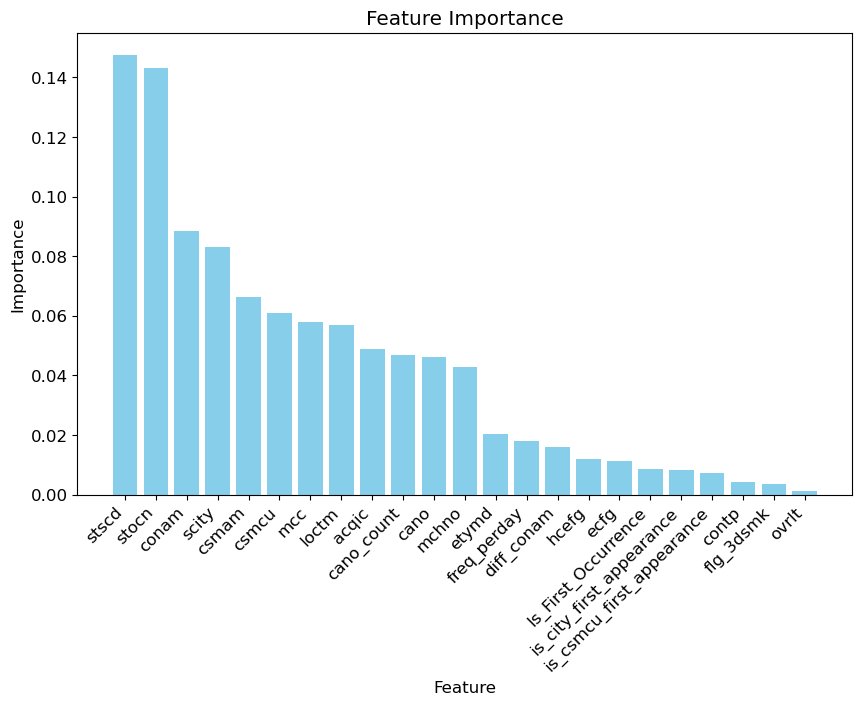

In [29]:
# Random forest 
feature_importance = rf_classifier.feature_importances_

feature_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importance
})

# 將 DataFrame 按照重要性排序
feature_importance_df = feature_importance_df.sort_values(by = 'Importance', ascending = False)

# 繪製條形圖
plt.figure(figsize = (10, 6))
plt.bar(feature_importance_df['Feature'], feature_importance_df['Importance'], color = 'skyblue')
plt.title('Feature Importance')
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.xticks(rotation=45, ha='right')  # 如果特徵名稱較多，可以旋轉 x 軸標籤
plt.show()


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimSun
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimSun
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimSun
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimSun
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimSun
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimSun
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimSun
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimSun
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimSun
findfont: Generic family 'sans-serif' not foun

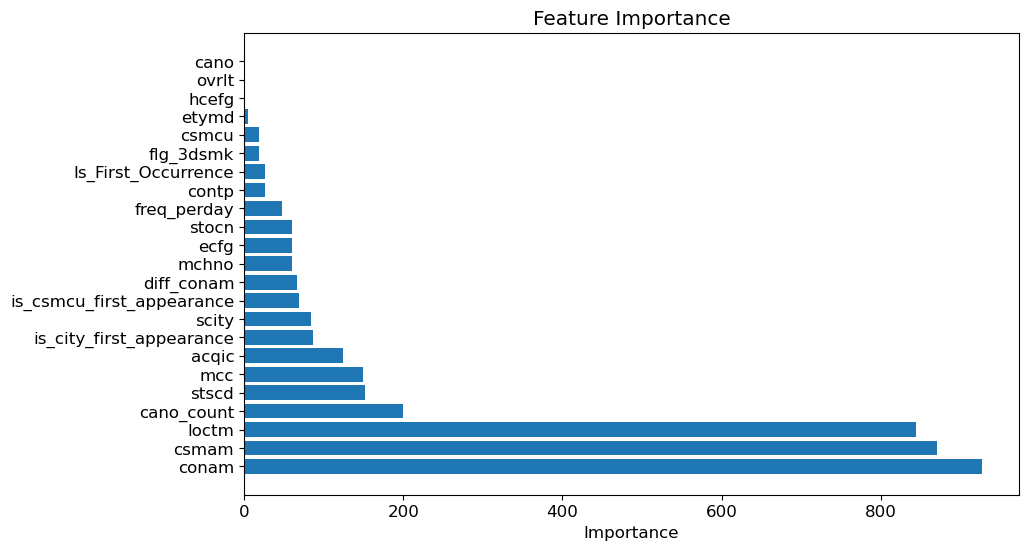

In [30]:
# Light GBM 
feature_importance = bst.feature_importance(importance_type = 'split')  # 或 'gain'，取決於你想要的類型

# 獲取特徵名稱
feature_names = bst.feature_name()

# 將特徵重要性轉換為 DataFrame
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importance})

# 依照特徵重要性降序排序
feature_importance_df = feature_importance_df.sort_values(by = 'Importance', ascending = False)

# 繪製特徵重要性圖表
plt.figure(figsize = (10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel('Importance')
plt.title('Feature Importance')
plt.show()

<AxesSubplot: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

findfont: Generic family 'sans-serif' not found because none of the following families were found: SimSun
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimSun
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimSun
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimSun
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimSun
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimSun
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimSun
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimSun
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimSun
findfont: Generic family 'sans-serif' not foun

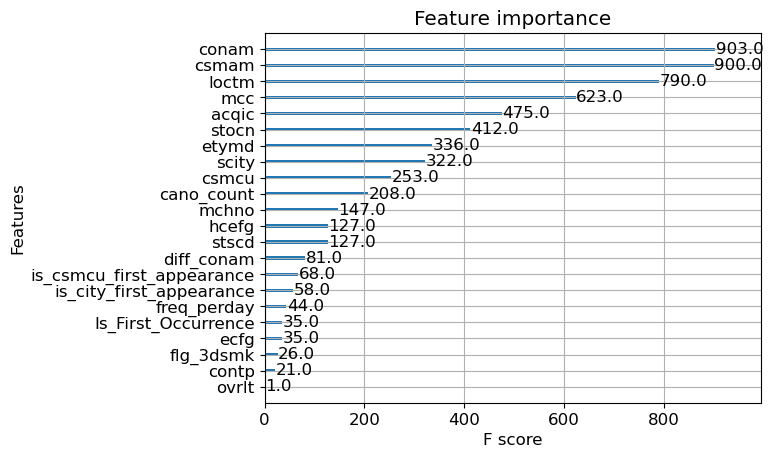

In [31]:
# XG boost
plot_importance(xgb_model)

findfont: Generic family 'sans-serif' not found because none of the following families were found: SimSun
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimSun
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimSun
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimSun
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimSun
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimSun
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimSun
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimSun
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimSun
findfont: Generic family 'sans-serif' not foun

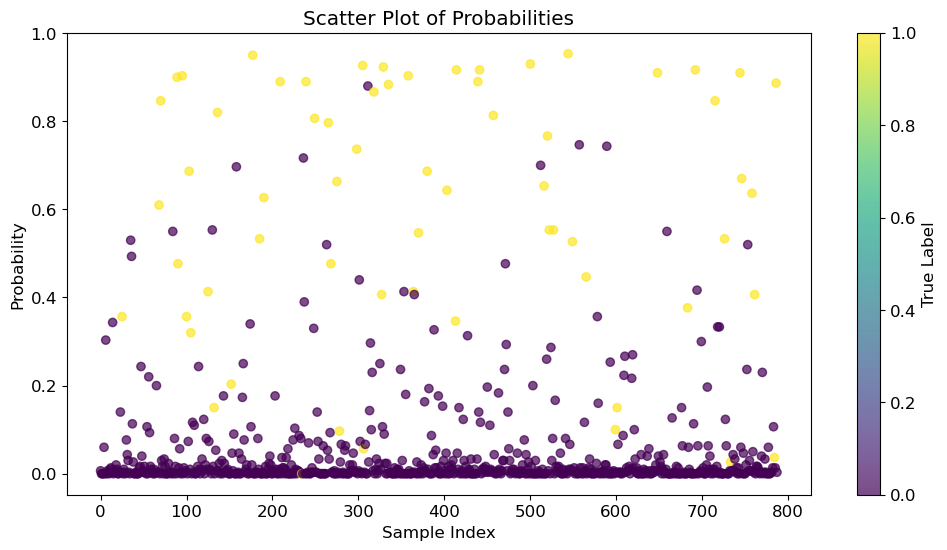

In [32]:
# Random forest
y_probabilities_rf = np.mean([estimator.predict_proba(X_test)[:, 1] for estimator in rf_classifier.estimators_], axis = 0)

plt.figure(figsize=(12, 6))
plt.scatter(range(len(y_test)), y_probabilities_rf, c= y_test.label, cmap='viridis', alpha=0.7)
plt.colorbar(label='True Label')
plt.title('Scatter Plot of Probabilities')
plt.xlabel('Sample Index')
plt.ylabel('Probability')
plt.show()

findfont: Generic family 'sans-serif' not found because none of the following families were found: SimSun
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimSun
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimSun
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimSun
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimSun
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimSun
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimSun
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimSun
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimSun
findfont: Generic family 'sans-serif' not foun

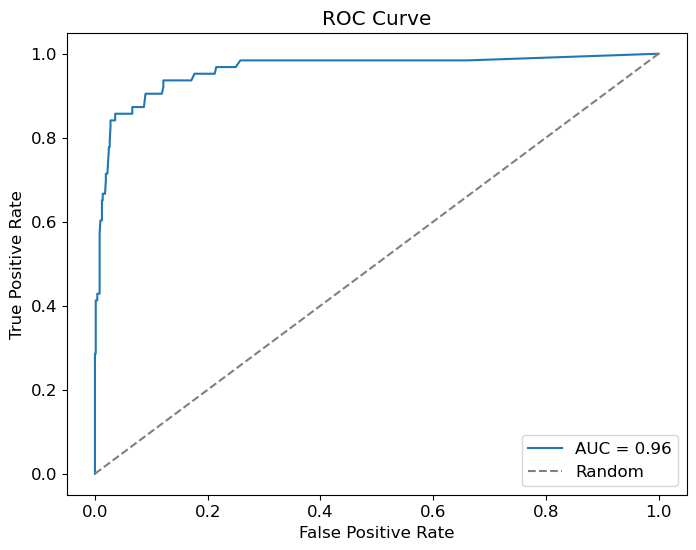

findfont: Generic family 'sans-serif' not found because none of the following families were found: SimSun
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimSun
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimSun
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimSun
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimSun
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimSun
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimSun
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimSun
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimSun
findfont: Generic family 'sans-serif' not foun

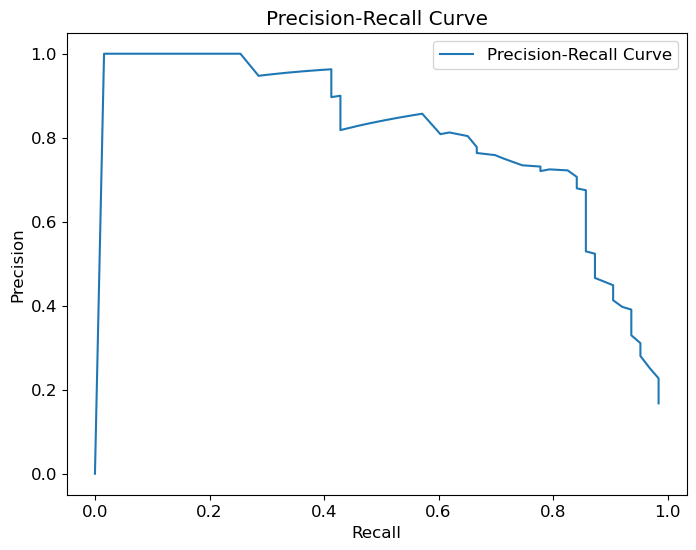

findfont: Generic family 'sans-serif' not found because none of the following families were found: SimSun
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimSun
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimSun
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimSun
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimSun
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimSun
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimSun
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimSun
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimSun
findfont: Generic family 'sans-serif' not foun

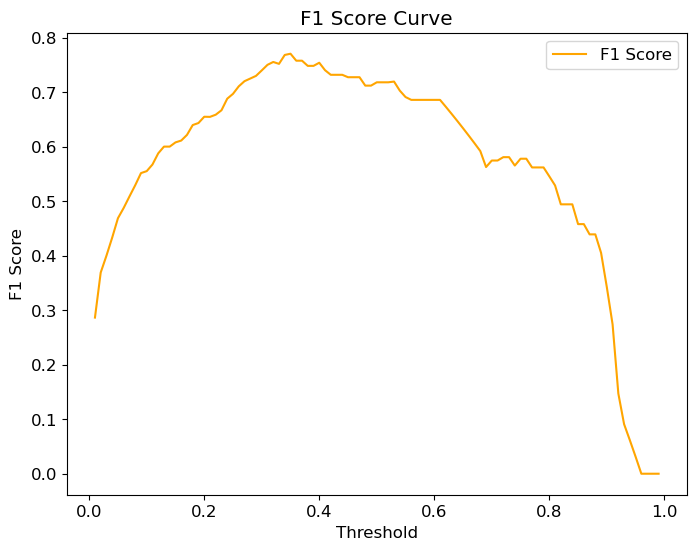

In [33]:
thresholds = np.arange(0.01, 1, 0.01)
predictions = [(y_probabilities_rf >= threshold).astype(int) for threshold in thresholds]
precision_values = [precision_score(y_test.label, prediction) for prediction in predictions]
recall_values = [recall_score(y_test.label, prediction) for prediction in predictions]
f1_values = [f1_score(y_test.label, y_probabilities_rf >= threshold) for threshold in thresholds]

# 計算 ROC 曲線
fpr, tpr, roc_thresholds = roc_curve(y_test.label, y_probabilities_rf)
roc_auc = auc(fpr, tpr)

# 繪製 ROC 曲線
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], '--', color='gray', label='Random')
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

# 繪製 precision-recall 曲線
plt.figure(figsize=(8, 6))
plt.plot(recall_values, precision_values, label='Precision-Recall Curve')
plt.title('Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.show()

# 繪製 F1 score 曲線
plt.figure(figsize=(8, 6))
plt.plot(thresholds, f1_values, label='F1 Score', color='orange')
plt.title('F1 Score Curve')
plt.xlabel('Threshold')
plt.ylabel('F1 Score')
plt.legend()
plt.show()

In [34]:
print(f"The max F1 score of RF is {max(f1_values)}")

The max F1 score of RF is 0.7703703703703704


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimSun
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimSun
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimSun
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimSun
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimSun
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimSun
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimSun
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimSun
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimSun
findfont: Generic family 'sans-serif' not foun

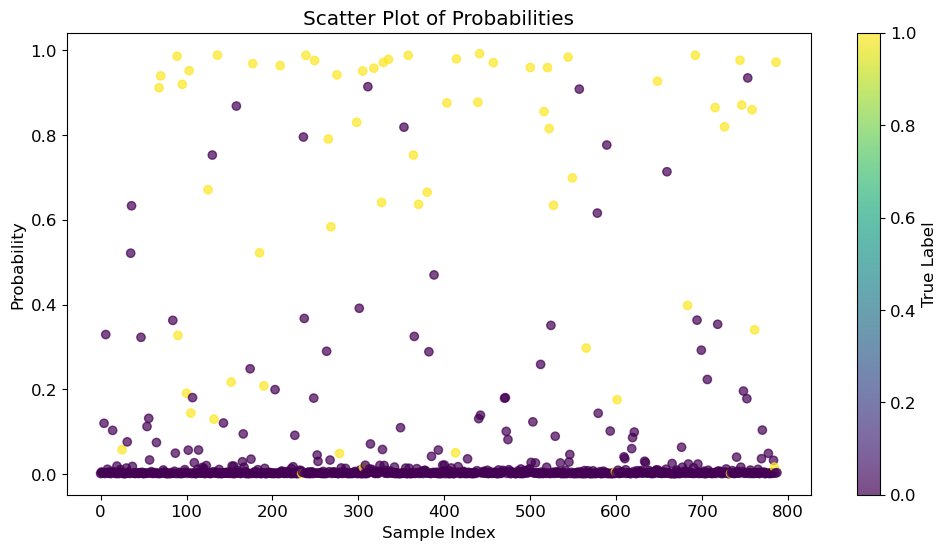

In [35]:
# light GBM
y_probabilities_lgbm = bst.predict(X_test, num_iteration = bst.best_iteration)

plt.figure(figsize = (12, 6))
plt.scatter(range(len(y_test)), y_probabilities_lgbm, c = y_test.label, cmap = 'viridis', alpha = 0.7)
plt.colorbar(label = 'True Label')
plt.title('Scatter Plot of Probabilities')
plt.xlabel('Sample Index')
plt.ylabel('Probability')
plt.show()

findfont: Generic family 'sans-serif' not found because none of the following families were found: SimSun
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimSun
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimSun
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimSun
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimSun
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimSun
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimSun
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimSun
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimSun
findfont: Generic family 'sans-serif' not foun

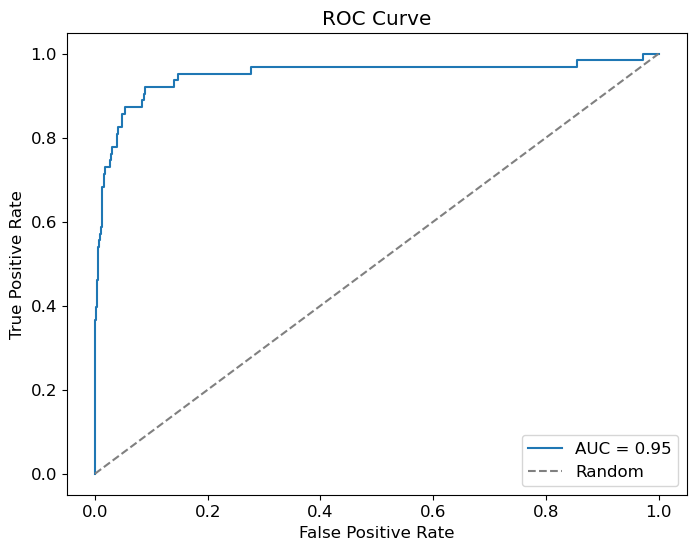

findfont: Generic family 'sans-serif' not found because none of the following families were found: SimSun
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimSun
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimSun
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimSun
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimSun
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimSun
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimSun
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimSun
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimSun
findfont: Generic family 'sans-serif' not foun

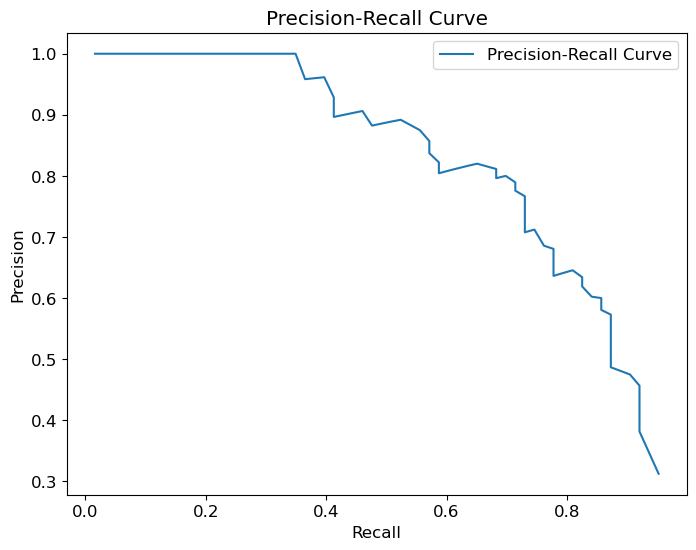

findfont: Generic family 'sans-serif' not found because none of the following families were found: SimSun
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimSun
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimSun
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimSun
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimSun
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimSun
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimSun
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimSun
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimSun
findfont: Generic family 'sans-serif' not foun

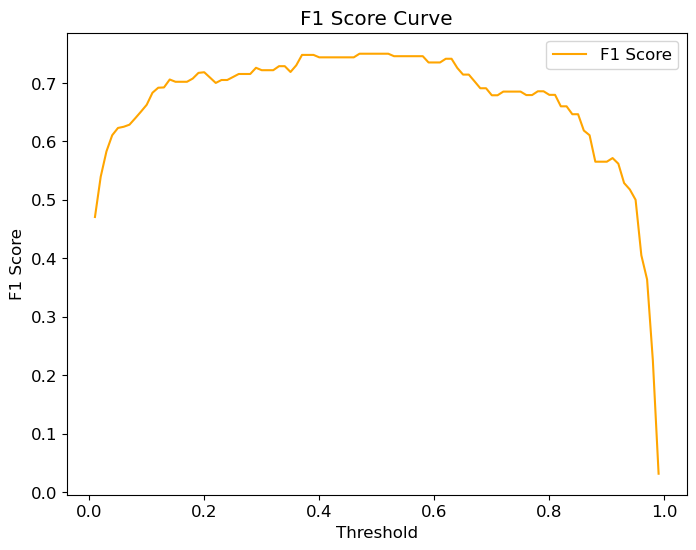

In [36]:
thresholds = np.arange(0.01, 1, 0.01)
predictions = [(y_probabilities_lgbm >= threshold).astype(int) for threshold in thresholds]
precision_values = [precision_score(y_test.label, prediction) for prediction in predictions]
recall_values = [recall_score(y_test.label, prediction) for prediction in predictions]
f1_values = [f1_score(y_test.label, y_probabilities_lgbm >= threshold) for threshold in thresholds]

# 計算 ROC 曲線
fpr, tpr, roc_thresholds = roc_curve(y_test.label, y_probabilities_lgbm)
roc_auc = auc(fpr, tpr)

# 繪製 ROC 曲線
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], '--', color='gray', label='Random')
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

# 繪製 precision-recall 曲線
plt.figure(figsize=(8, 6))
plt.plot(recall_values, precision_values, label='Precision-Recall Curve')
plt.title('Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.show()

# 繪製 F1 score 曲線
plt.figure(figsize=(8, 6))
plt.plot(thresholds, f1_values, label='F1 Score', color='orange')
plt.title('F1 Score Curve')
plt.xlabel('Threshold')
plt.ylabel('F1 Score')
plt.legend()
plt.show()

In [37]:
print(f"The max F1 score of Light GBM is {max(f1_values)}")

The max F1 score of Light GBM is 0.75


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimSun
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimSun
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimSun
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimSun
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimSun
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimSun
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimSun
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimSun
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimSun
findfont: Generic family 'sans-serif' not foun

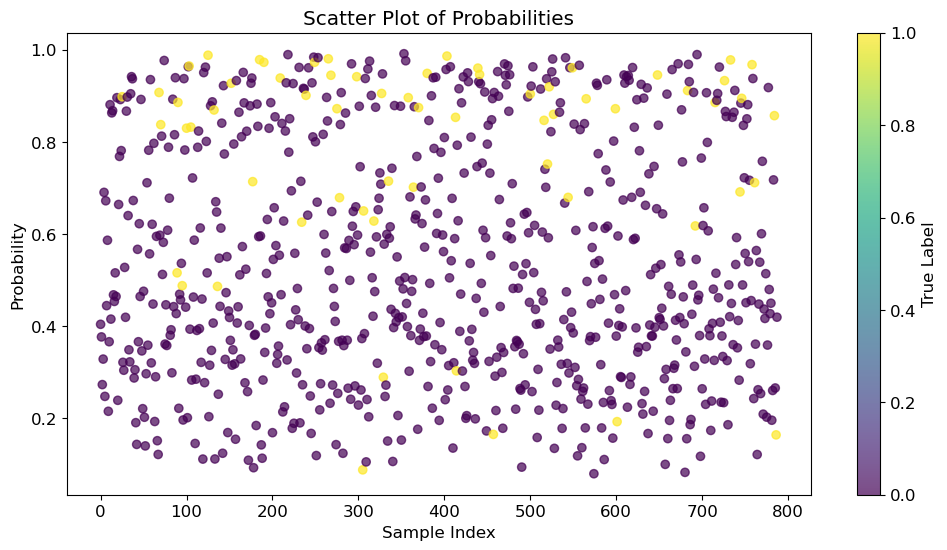

In [38]:
# XG boost
y_probabilities_xgb = xgb_model.predict_proba(X_test)[:,1]
plt.figure(figsize=(12, 6))
plt.scatter(range(len(y_test)), y_probabilities_xgb, c= y_test.label, cmap='viridis', alpha=0.7)
plt.colorbar(label='True Label')
plt.title('Scatter Plot of Probabilities')
plt.xlabel('Sample Index')
plt.ylabel('Probability')
plt.show()

findfont: Generic family 'sans-serif' not found because none of the following families were found: SimSun
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimSun
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimSun
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimSun
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimSun
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimSun
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimSun
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimSun
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimSun
findfont: Generic family 'sans-serif' not foun

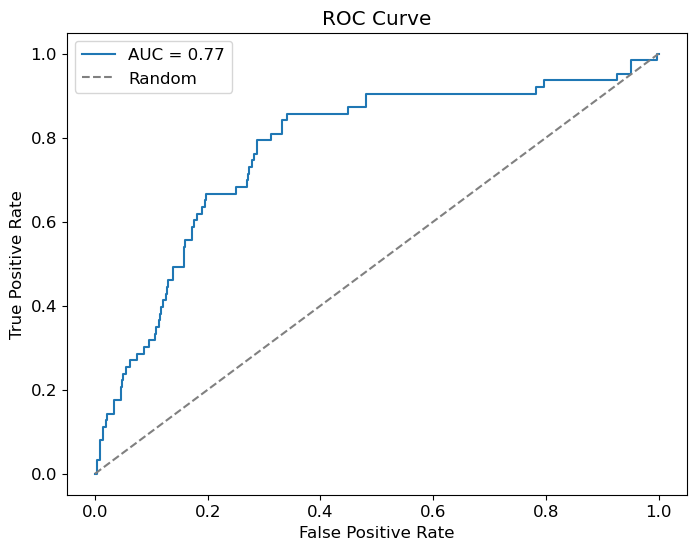

findfont: Generic family 'sans-serif' not found because none of the following families were found: SimSun
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimSun
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimSun
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimSun
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimSun
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimSun
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimSun
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimSun
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimSun
findfont: Generic family 'sans-serif' not foun

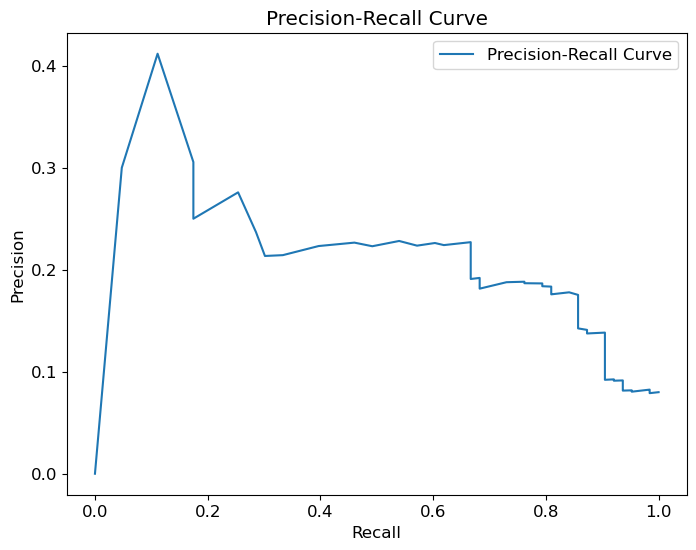

findfont: Generic family 'sans-serif' not found because none of the following families were found: SimSun
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimSun
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimSun
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimSun
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimSun
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimSun
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimSun
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimSun
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimSun
findfont: Generic family 'sans-serif' not foun

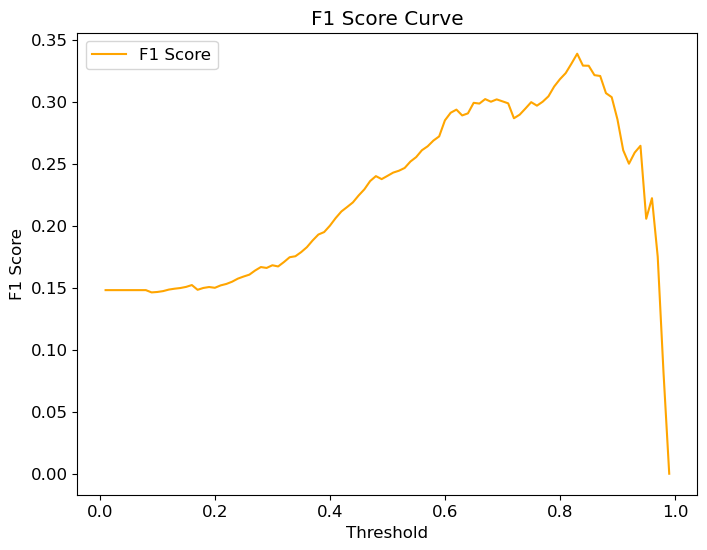

In [39]:
thresholds = np.arange(0.01, 1, 0.01)
predictions = [(y_probabilities_xgb >= threshold).astype(int) for threshold in thresholds]
precision_values = [precision_score(y_test.label, prediction) for prediction in predictions]
recall_values = [recall_score(y_test.label, prediction) for prediction in predictions]
f1_values = [f1_score(y_test.label, y_probabilities_xgb >= threshold) for threshold in thresholds]

# 計算 ROC 曲線
fpr, tpr, roc_thresholds = roc_curve(y_test.label, y_probabilities_xgb)
roc_auc = auc(fpr, tpr)

# 繪製 ROC 曲線
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], '--', color='gray', label='Random')
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

# 繪製 precision-recall 曲線
plt.figure(figsize=(8, 6))
plt.plot(recall_values, precision_values, label='Precision-Recall Curve')
plt.title('Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.show()

# 繪製 F1 score 曲線
plt.figure(figsize=(8, 6))
plt.plot(thresholds, f1_values, label='F1 Score', color='orange')
plt.title('F1 Score Curve')
plt.xlabel('Threshold')
plt.ylabel('F1 Score')
plt.legend()
plt.show()

In [40]:
print(f"The max F1 score of XG Boost is {max(f1_values)}")

The max F1 score of XG Boost is 0.3387096774193548


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimSun
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimSun
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimSun
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimSun
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimSun
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimSun
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimSun
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimSun
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimSun
findfont: Generic family 'sans-serif' not foun

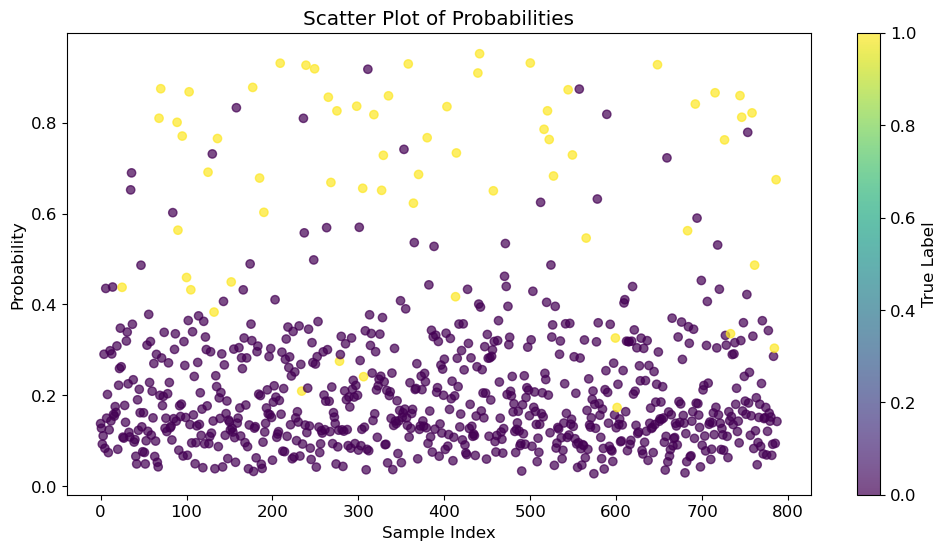

In [41]:
# Integrated all the result 
y_probabilities_xgb_train = xgb_model.predict_proba(X_test)[:,1]

y_probabilities_lgbm_train = bst.predict(X_test, 
                                         num_iteration = bst.best_iteration
                                         )

y_probabilities_rf_train = np.mean([estimator.predict_proba(X_test)[:, 1] for estimator in rf_classifier.estimators_], axis=0)

y_probabilities = (y_probabilities_rf_train + y_probabilities_lgbm_train + y_probabilities_xgb_train) / 3


plt.figure(figsize = (12, 6))
plt.scatter(range(len(y_test)), y_probabilities, c =  y_test.label, cmap = 'viridis', alpha = 0.7)
plt.colorbar(label = 'True Label')
plt.title('Scatter Plot of Probabilities')
plt.xlabel('Sample Index')
plt.ylabel('Probability')
plt.show()

findfont: Generic family 'sans-serif' not found because none of the following families were found: SimSun
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimSun
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimSun
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimSun
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimSun
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimSun
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimSun
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimSun
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimSun
findfont: Generic family 'sans-serif' not foun

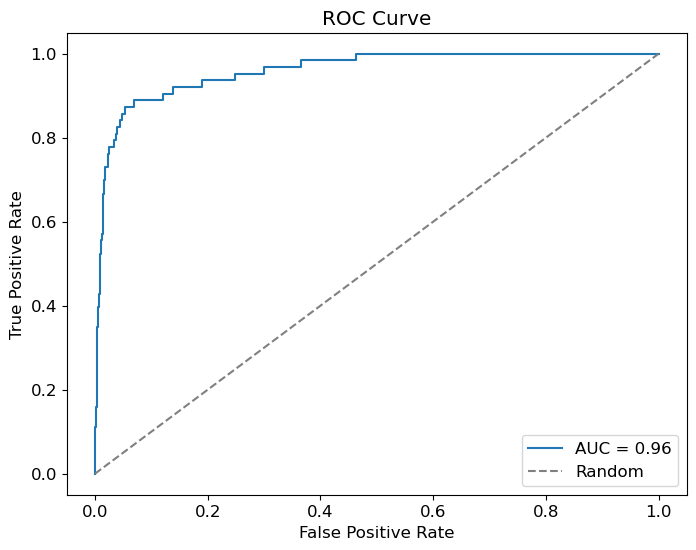

findfont: Generic family 'sans-serif' not found because none of the following families were found: SimSun
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimSun
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimSun
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimSun
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimSun
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimSun
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimSun
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimSun
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimSun
findfont: Generic family 'sans-serif' not foun

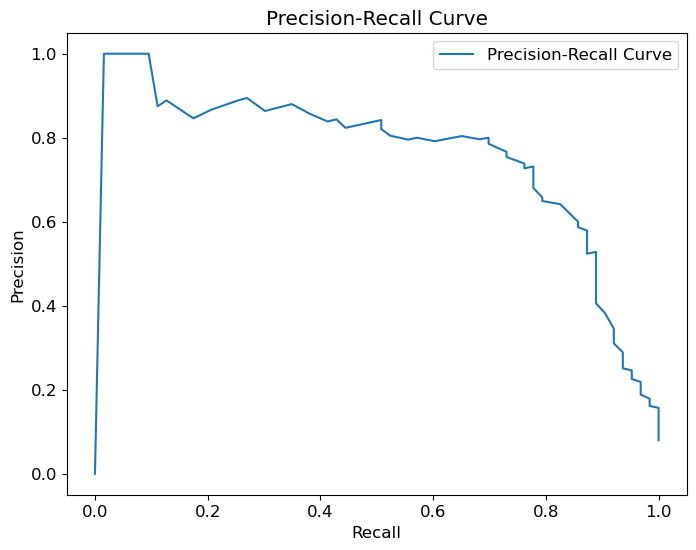

findfont: Generic family 'sans-serif' not found because none of the following families were found: SimSun
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimSun
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimSun
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimSun
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimSun
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimSun
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimSun
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimSun
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimSun
findfont: Generic family 'sans-serif' not foun

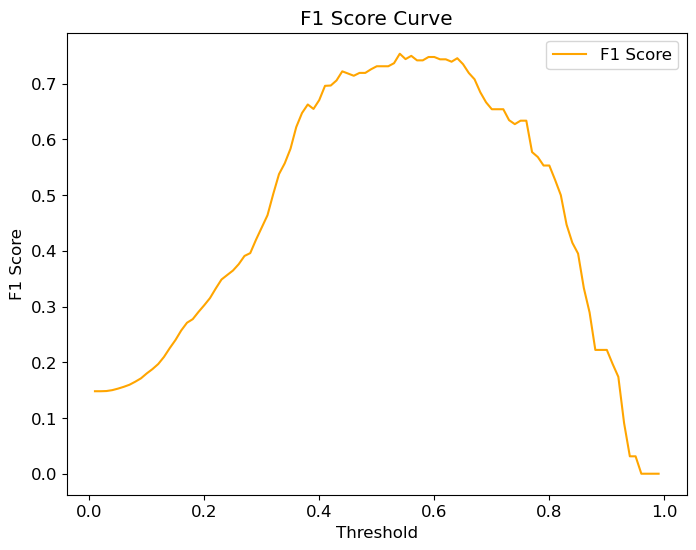

In [42]:
thresholds = np.arange(0.01, 1, 0.01)
predictions = [(y_probabilities >= threshold).astype(int) for threshold in thresholds]
precision_values = [precision_score(y_test.label, prediction) for prediction in predictions]
recall_values = [recall_score(y_test.label, prediction) for prediction in predictions]
f1_values = [f1_score(y_test.label, y_probabilities >= threshold) for threshold in thresholds]

# 計算 ROC 曲線
fpr, tpr, roc_thresholds = roc_curve(y_test.label, y_probabilities)
roc_auc = auc(fpr, tpr)

# 繪製 ROC 曲線
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], '--', color='gray', label='Random')
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

# 繪製 precision-recall 曲線
plt.figure(figsize=(8, 6))
plt.plot(recall_values, precision_values, label='Precision-Recall Curve')
plt.title('Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.show()

# 繪製 F1 score 曲線
plt.figure(figsize=(8, 6))
plt.plot(thresholds, f1_values, label='F1 Score', color='orange')
plt.title('F1 Score Curve')
plt.xlabel('Threshold')
plt.ylabel('F1 Score')
plt.legend()
plt.show()

In [43]:
print(f"The max F1 score of emsemble result is {max(f1_values)}")

The max F1 score of emsemble result is 0.7538461538461538


In [44]:
thresholds[np.argmax(f1_values)]

0.54

上面那個不能那麼高（應該

# 記得用一下grid search

In [45]:
# import numpy as np
# import pandas as pd
# from sklearn.model_selection import GridSearchCV
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import mean_squared_error
# import xgboost as xgb

# # 假设您已经有了数据集 X 和目标变量 y
# # X = ...
# # y = ...

# # 分割数据集
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# # 创建 XGBoost 回归器对象
# xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)

# # 定义参数网格
# param_grid = {
#     'max_depth': [3, 5, 7],
#     'learning_rate': [0.01, 0.1, 0.3],
#     'n_estimators': [100, 200, 300],
#     'min_child_weight': [1, 3, 5],
#     'subsample': [0.7, 0.8, 0.9]
# }

# # 创建 GridSearchCV 对象
# grid_search = GridSearchCV(
#     estimator=xgb_model,
#     param_grid=param_grid,
#     cv=5,
#     scoring='neg_mean_squared_error',
#     n_jobs=-1,
#     verbose=2
# )

# # 执行网格搜索
# grid_search.fit(X_train, y_train)

# # 输出最佳参数和得分
# print("Best parameters found: ", grid_search.best_params_)
# print("Best cross-validation score: ", -grid_search.best_score_)

# # 使用最佳参数的模型进行预测
# best_model = grid_search.best_estimator_
# y_pred = best_model.predict(X_test)

# # 计算测试集上的均方误差
# mse = mean_squared_error(y_test, y_pred)
# print("Mean squared error on test set: ", mse)

# # 特征重要性
# feature_importance = best_model.feature_importances_
# feature_names = X.columns
# importance_df = pd.DataFrame({'feature': feature_names, 'importance': feature_importance})
# importance_df = importance_df.sort_values('importance', ascending=False)
# print("\nFeature Importance:")
# print(importance_df)

## 4. Prediction on testing data

我們根據從 Step3 得到的模型以及最佳的 threshold 來對我們的 testing set 進行預測。

In [46]:
#Test set data
# etymd 補值 99 表示 NA, 
# mcc 用 999 表示 NA
# stocn 補值 999 表示 NA (600 筆有 25 筆 fraud)
# scity 用 999 表示 NA
# stscd 這個欄位非常重要，不能去除，因為在有狀態碼的資料中，有 50% 的資料是盜刷!，用 99 來當作 NA 的補值
# hcefg 補值 99 表示 NA
# csmcu 補值 99 表示 NA 

cols_test = df_raw_test.columns
[{f"{cols_test[i]}":df_raw_test[f'{cols_test[i]}'].isna().sum()} for i in range(len(cols_test))]


[{'txkey': 343},
 {'locdt': 304},
 {'loctm': 314},
 {'chid': 311},
 {'cano': 302},
 {'contp': 352},
 {'etymd': 362},
 {'mchno': 324},
 {'acqic': 330},
 {'mcc': 336},
 {'conam': 281},
 {'ecfg': 341},
 {'stocn': 324},
 {'scity': 353},
 {'stscd': 1911},
 {'ovrlt': 302},
 {'hcefg': 371},
 {'csmcu': 385},
 {'csmam': 307},
 {'flg_3dsmk': 0},
 {'diff_conam': 539},
 {'is_city_first_appearance': 0},
 {'is_csmcu_first_appearance': 0},
 {'cano_count': 302},
 {'Is_First_Occurrence': 0},
 {'freq_perday': 570}]

In [58]:
cols_test

Index(['txkey', 'locdt', 'loctm', 'chid', 'cano', 'contp', 'etymd', 'mchno',
       'acqic', 'mcc', 'conam', 'ecfg', 'stocn', 'scity', 'stscd', 'ovrlt',
       'hcefg', 'csmcu', 'csmam', 'flg_3dsmk', 'diff_conam',
       'is_city_first_appearance', 'is_csmcu_first_appearance', 'cano_count',
       'Is_First_Occurrence', 'freq_perday'],
      dtype='object')

In [47]:
# deal with test data
df_raw_test['etymd'] = df_raw_test['etymd'].fillna(99)
df_raw_test['stscd'] = df_raw_test['stscd'].fillna(99)

df_raw_test['stocn'] = df_raw_test['stocn'].fillna(999)
df_raw_test['hcefg'] = df_raw_test['hcefg'].fillna(999)
df_raw_test['csmcu'] = df_raw_test['csmcu'].fillna(999)
df_raw_test['mcc'] = df_raw_test['mcc'].fillna(999)
df_raw_test['scity'] = df_raw_test['scity'].fillna(999)

[{f"{cols_test[i]}":df_raw_test[f'{cols_test[i]}'].isna().sum()} for i in range(len(cols_test))]

[{'txkey': 343},
 {'locdt': 304},
 {'loctm': 314},
 {'chid': 311},
 {'cano': 302},
 {'contp': 352},
 {'etymd': 0},
 {'mchno': 324},
 {'acqic': 330},
 {'mcc': 0},
 {'conam': 281},
 {'ecfg': 341},
 {'stocn': 0},
 {'scity': 0},
 {'stscd': 0},
 {'ovrlt': 302},
 {'hcefg': 0},
 {'csmcu': 0},
 {'csmam': 307},
 {'flg_3dsmk': 0},
 {'diff_conam': 539},
 {'is_city_first_appearance': 0},
 {'is_csmcu_first_appearance': 0},
 {'cano_count': 302},
 {'Is_First_Occurrence': 0},
 {'freq_perday': 570}]

In [48]:
# 因為 map 過去後還是會遇到沒有對應值的情形，此時就會產生 NA，因此我們將 NA 都補值 (999)

df_raw_test['mchno'] = df_raw_test['mchno'].map(dict_mchno)
df_raw_test['acqic'] = df_raw_test['acqic'].map(dict_acqic)
df_raw_test['cano'] = df_raw_test['cano'].map(dict_cano)


In [49]:
df_raw_test['mchno'] = df_raw_test['mchno'].fillna(9999)
df_raw_test['acqic'] = df_raw_test['acqic'].fillna(9999)
df_raw_test['cano'] = df_raw_test['cano'].fillna(999)

In [50]:
# model fitting
X_test_pub = df_raw_test.drop(['txkey','locdt','chid'], 
                              axis = 1, inplace = False
                              )

X_test_pub = X_test_pub.astype(dtype = 'category')

In [51]:
print(X_test_pub.columns)

Index(['loctm', 'cano', 'contp', 'etymd', 'mchno', 'acqic', 'mcc', 'conam',
       'ecfg', 'stocn', 'scity', 'stscd', 'ovrlt', 'hcefg', 'csmcu', 'csmam',
       'flg_3dsmk', 'diff_conam', 'is_city_first_appearance',
       'is_csmcu_first_appearance', 'cano_count', 'Is_First_Occurrence',
       'freq_perday'],
      dtype='object')


In [52]:
# """
# Cell generated by Data Wrangler.
# """
# def clean_data(X_test_pub):
#     # Drop rows with missing data across all columns
#     X_test_pub = X_test_pub.dropna()
#     return X_test_pub

# X_test_pub = clean_data(X_test_pub.copy())

In [61]:
"""
Cell generated by Data Wrangler.
"""
def clean_data(X_test_pub):
    # Change column type to float64 for column: 'freq_perday'
    X_test_pub = X_test_pub.astype({'freq_perday': 'float64'})
    # Change column type to float64 for column: 'cano_count'
    X_test_pub = X_test_pub.astype({'cano_count': 'float64'})
    # Change column type to float64 for column: 'loctm'
    X_test_pub = X_test_pub.astype({'loctm': 'float64'})
    return X_test_pub

X_test_pub = clean_data(X_test_pub.copy())
X_test_pub.head()

,loctm,cano,contp,etymd,mchno,acqic,mcc,conam,ecfg,stocn,...,hcefg,csmcu,csmam,flg_3dsmk,diff_conam,is_city_first_appearance,is_csmcu_first_appearance,cano_count,Is_First_Occurrence,freq_perday
0,NaN,999.0,5.0,5.0,9999.0,300.0,406.0,76.839628,1.0,999.0,...,6.0,70.0,-329.356052,0.0,0.0,True,True,1.0,True,1.0
1,50236.0,999.0,5.0,8.0,1160.0,282.0,324.0,272.087939,1.0,40.0,...,999.0,29.0,84.482536,0.0,NaN,False,False,NaN,False,NaN
2,4104.0,999.0,5.0,8.0,748.0,227.0,326.0,1061.161690,1.0,999.0,...,6.0,999.0,1530.061345,0.0,NaN,False,False,NaN,False,NaN
3,101305.0,999.0,NaN,1.0,830.0,300.0,375.0,387.208488,0.0,0.0,...,6.0,70.0,54.312320,0.0,NaN,False,False,NaN,False,NaN
4,103356.0,999.0,5.0,99.0,1740.0,168.0,999.0,232.583468,NaN,126.0,...,0.0,999.0,48.464017,0.0,0.0,False,False,1.0,True,1.0


In [65]:
# 1. 檢查 'cano_count' 列的情況
print(X_test_pub['cano_count'].describe())
print("NaN 值的數量:", X_test_pub['cano_count'].isna().sum())
print("無限值的數量:", np.isinf(X_test_pub['cano_count']).sum())

# 2. 處理 NaN 和無限值
# 方法 A: 用 0 或其他適當的值填充 NaN 和無限值
X_test_pub['cano_count'] = X_test_pub['cano_count'].fillna(0)
X_test_pub['cano_count'] = X_test_pub['cano_count'].replace([np.inf, -np.inf], 0)

# 方法 B: 或者，如果你想刪除這些行
# X_test_pub = X_test_pub.dropna(subset=['cano_count'])
# X_test_pub = X_test_pub[~np.isinf(X_test_pub['cano_count'])]

# 3. 安全地轉換為整數類型
X_test_pub['cano_count'] = X_test_pub['cano_count'].astype('int')

# 4. 對其他列進行類似的處理
columns_to_convert = ['csmam', 'loctm', 'freq_perday']

for col in columns_to_convert:
    # 檢查並處理 NaN 和無限值
    X_test_pub[col] = X_test_pub[col].fillna(X_test_pub[col].median())  # 使用中位數填充 NaN
    X_test_pub[col] = X_test_pub[col].replace([np.inf, -np.inf], X_test_pub[col].median())  # 處理無限值
    
    # 根據需要轉換數據類型
    if col in ['csmam', 'freq_perday']:
        X_test_pub[col] = X_test_pub[col].astype('float')
    elif col in ['loctm']:
        X_test_pub[col] = X_test_pub[col].astype('int')

# 5. 確認轉換結果
print(X_test_pub[['cano_count', 'csmam', 'loctm', 'freq_perday']].dtypes)

count    1798.000000
mean        1.755284
std         2.359263
min         1.000000
25%         1.000000
50%         1.000000
75%         1.000000
max        19.000000
Name: cano_count, dtype: float64
NaN 值的數量: 302
無限值的數量: 0
cano_count       int64
csmam          float64
loctm            int64
freq_perday    float64
dtype: object


In [66]:
X_test_pub['conam'] = X_test_pub['conam'].astype('float')
# X_test_pub['iterm'] = X_test_pub['iterm'].astype('int')
# X_test_pub['flam1'] = X_test_pub['flam1'].astype('float')
X_test_pub['csmam'] = X_test_pub['csmam'].astype('float')
X_test_pub['cano_count'] = X_test_pub['cano_count'].astype('int')
X_test_pub['loctm'] = X_test_pub['loctm'].astype('int')
X_test_pub['freq_perday'] = X_test_pub['freq_perday'].astype('int')
X_test_pub['diff_conam'] = X_test_pub['diff_conam'].astype('float')


In [67]:
y_probabilities_lgbm = bst.predict(X_test_pub, 
                                   num_iteration = bst.best_iteration
                                   )

y_probabilities_rf = np.mean([estimator.predict_proba(X_test_pub)[:, 1] for estimator in rf_classifier.estimators_], axis=0)

y_probabilities_xgb = xgb_model.predict_proba(X_test_pub)[:,1]

y_probabilities = (y_probabilities_lgbm + y_probabilities_rf + y_probabilities_xgb)/3

In [82]:
predictions = (y_probabilities >= 0.36).astype(int)
df_raw_test['label'] = predictions

In [85]:
df_out = df_raw_test[['label']]
df_out['index'] = range(len(df_out))

# 重新排列列的顺序，使 'index' 在 'label' 之前
df_out = df_out[['index', 'label']]
# df_out.to_csv('RF+LightGBM+XG_final1.csv', 
#               index = False, 
#               encoding = 'utf-8'
#               )

In [86]:
df_out

,index,label
0,0,0
1,1,1
2,2,1
3,3,0
4,4,1
...,...,...
2095,2095,1
2096,2096,0
2097,2097,0
2098,2098,0


In [87]:
df_out.to_csv('RF+LightGBM+XG_final1.csv', 
              index = False, 
              encoding = 'utf-8')